_Neural Data Science_

Lecturer: Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Rita González Márquez, Fabio Seel

Summer term 2024

Student names: *FILL IN YOUR NAMES HERE*

# Coding Lab 2

- __Data__: Use the saved data `nds_cl_1_*.npy` from Coding Lab 1. Or, if needed, download the data files ```nds_cl_1_*.npy``` from ILIAS and save it in the subfolder ```../data/```.
- __Dependencies__: You don't have to use the exact versions of all the dependencies in this notebook, as long as they are new enough. But if you run "Run All" in Jupyter and the boilerplate code breaks, you probably need to upgrade them.

In [5]:
import numpy as np
import scipy as sp 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from __future__ import annotations

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2024-05-03 17:40:04Mitteleuropäische Sommerzeit

Python implementation: CPython
Python version       : 3.9.18
IPython version      : 8.18.1

sklearn: 1.4.2

scipy     : 1.13.0
matplotlib: 3.8.4
numpy     : 1.26.4

Watermark: 2.4.3



In [6]:
plt.style.use("../matplotlib_style.txt")

## Load data

In [7]:
# replace by path to your solutions
b = np.load("../data/nds_cl_1_features.npy")
s = np.load("../data/nds_cl_1_spiketimes_s.npy")
w = np.load("../data/nds_cl_1_waveforms.npy")
np.random.seed(0)

## Task 1: Generate toy data

Sample 1000 data points from a two dimensional mixture of Gaussian model with three clusters  and the following parameters:

$\mu_1 = \begin{bmatrix}0\\0\end{bmatrix}, \Sigma_1 = \begin{bmatrix}1 & 0\\0 & 1\end{bmatrix}, \pi_1=0.3$

$\mu_2 = \begin{bmatrix}5\\1\end{bmatrix}, \Sigma_2 = \begin{bmatrix}2 & 1\\1 & 2\end{bmatrix}, \pi_2=0.5$

$\mu_3 = \begin{bmatrix}0\\4\end{bmatrix}, \Sigma_3 = \begin{bmatrix}1 & -0.5\\-0.5 & 1\end{bmatrix}, \pi_3=0.2$

Plot the sampled data points and indicate in color the cluster each point came from. Plot the cluster means as well.

*Grading: 1 pts*


In [8]:
def sample_data(
    n_samples: int, m: np.ndarray, S: np.ndarray, p: np.ndarray, random_seed: int = 2046
) -> tuple[np.ndarray, np.ndarray]:
    """Generate n_samples samples from a Mixture of Gaussian distribution with
    means m, covariances S and priors p.

    Parameters
    ----------

    n_samples: int
        Number of samples

    m: np.ndarray, (n_clusters, n_dims)
        Means

    S: np.ndarray, (n_clusters, n_dims, n_dims)
        Covariances

    p: np.ndarray, (n_clusters, )
        Cluster weights / probablities

    random_seed: int
        Random Seed

    Returns
    -------

    labels: np.array, (n_samples, )
        Grund truth labels.

    x: np.array, (n_samples, n_dims)
        Data points
    """
    # ensure reproducibility using a random number generator
    # hint: access random functions of this generator
    rng = np.random.default_rng(random_seed)

    # initiate data_point_vector as list for easier appending
    # (I am not using list comprehension, because in this case, I can populate both arrays with one loop)
    x = []
    labels = []

    # iterate over clusters
    for label, (mean, cov, weight) in enumerate(zip(m, S, p)):
        cluster_size = int(weight * n_samples)
        cluster = rng.multivariate_normal(mean=mean, cov=cov, size=cluster_size)

        x.append(cluster)
        labels.append([label] * cluster_size)

    # make into arrays
    x = np.concatenate(x)
    labels = np.concatenate(labels)

    # ------------------------------------------------------
    # draw labeled points from mixture of Gaussians (0.5 pt)
    # ------------------------------------------------------

    # clear plot (just in case)
    plt.cla()
    # plot clusters
    plt.scatter(x[:, 0], x[:, 1], c=labels)
    # plot cluster means
    plt.scatter(m[:, 0], m[:, 1], c="r")
    plt.show()

    return labels, x

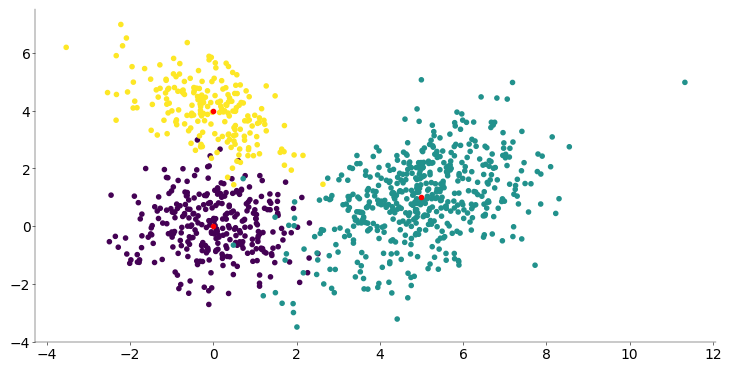

In [9]:
N = 1000  # total number of samples

p = np.array([0.3, 0.5, 0.2])  # percentage of each cluster
m = np.array([[0.0, 0.0], [5.0, 1.0], [0.0, 4.0]])  # means

S1 = np.array([[1.0, 0.0], [0.0, 1.0]])
S2 = np.array([[2.0, 1.0], [1.0, 2.0]])
S3 = np.array([[1.0, -0.5], [-0.5, 1.0]])
S = np.stack([S1, S2, S3])  # cov

labels, x = sample_data(N, m, S, p)

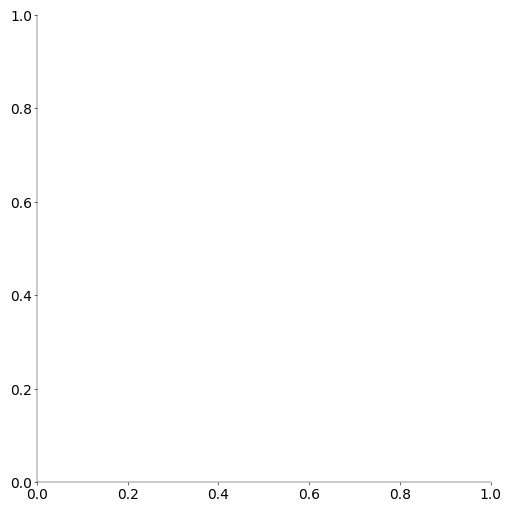

In [10]:
# ----------------------------------------------
# plot points from mixture of Gaussians (0.5 pt)
# ----------------------------------------------

fig, ax = plt.subplots(figsize=(5, 5))

## Task 2: Implement a Gaussian mixture model

Implement the EM algorithm to fit a Gaussian mixture model in `fit_mog()`.  Sort the data points by inferring their class labels from your mixture model (by using maximum a-posteriori classification). Fix the seed of the random number generator to ensure deterministic and reproducible behavior. Test it on the toy dataset specifying the correct number of clusters and make sure the code works correctly. Plot the data points from the toy dataset and indicate in color the cluster each point was assigned to by your model. How does the assignment compare to ground truth? If you run the algorithm multiple times, you will notice that some solutions provide suboptimal clustering solutions - depending on your initialization strategy.  

*Grading: 4 pts*


[[0.68863973]
 [0.11192006]
 [0.1994402 ]]
m: [[ 0.59167237  0.17711502]
 [ 2.70988352 -0.48871908]
 [ 8.87535733  6.07713967]]
S: [[[ 2.50889107e+03  7.50397841e+02]
  [ 7.50397841e+02  2.88196674e+02]]

 [[ 5.00194092e+02 -2.42939217e+01]
  [-2.42939217e+01  6.45871569e+01]]

 [[ 4.77094643e+04  2.83349900e+04]
  [ 2.83349900e+04  2.28195692e+04]]]


c:\Users\ralfk\Desktop\Uni Stuff\MA\Semester 4\Neural Data Science\Coding\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


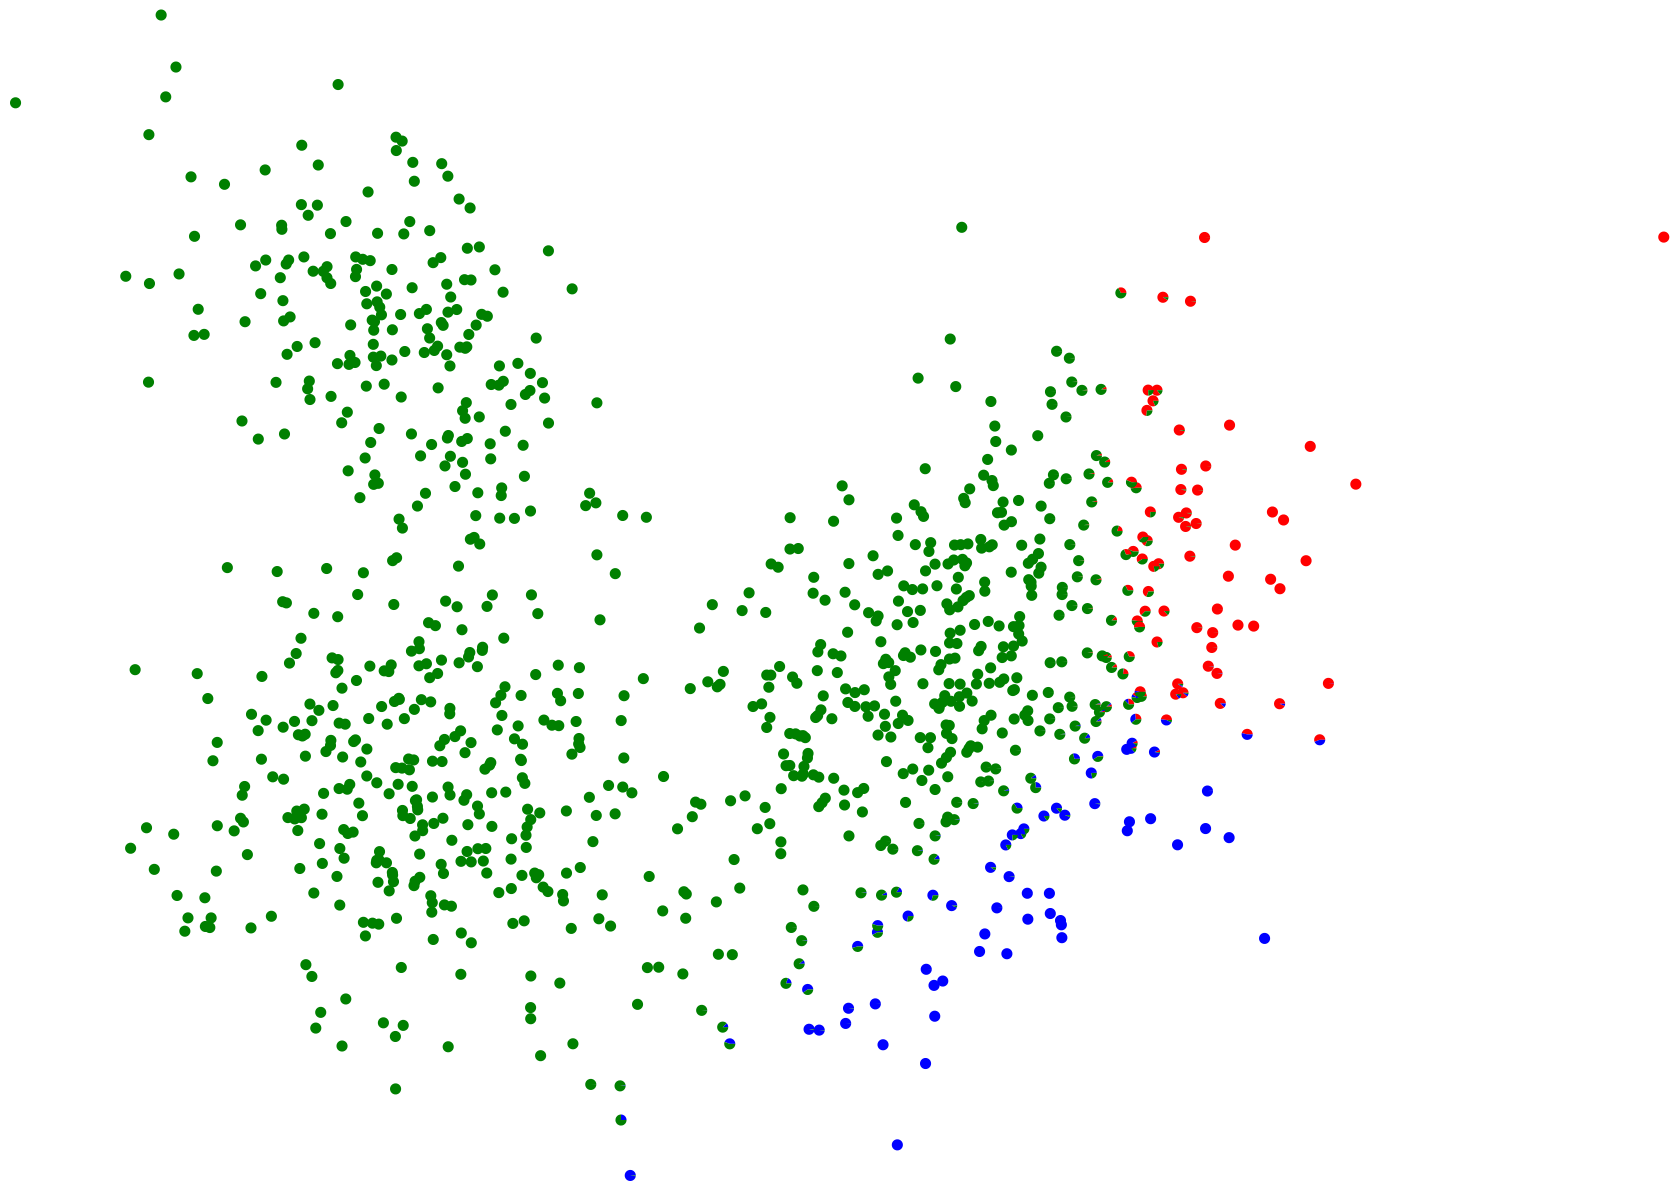

m: [[12.05937346  6.17879423]
 [27.88111181 14.61632589]
 [ 0.28133012  0.13265559]]
S: [[[2.76512884e+04 1.28961530e+04]
  [1.28961530e+04 7.69399527e+03]]

 [[4.07278792e+05 2.10612100e+05]
  [2.10612100e+05 1.12825457e+05]]

 [[1.25350547e+03 1.95121603e+02]
  [1.95121603e+02 4.42648179e+02]]]


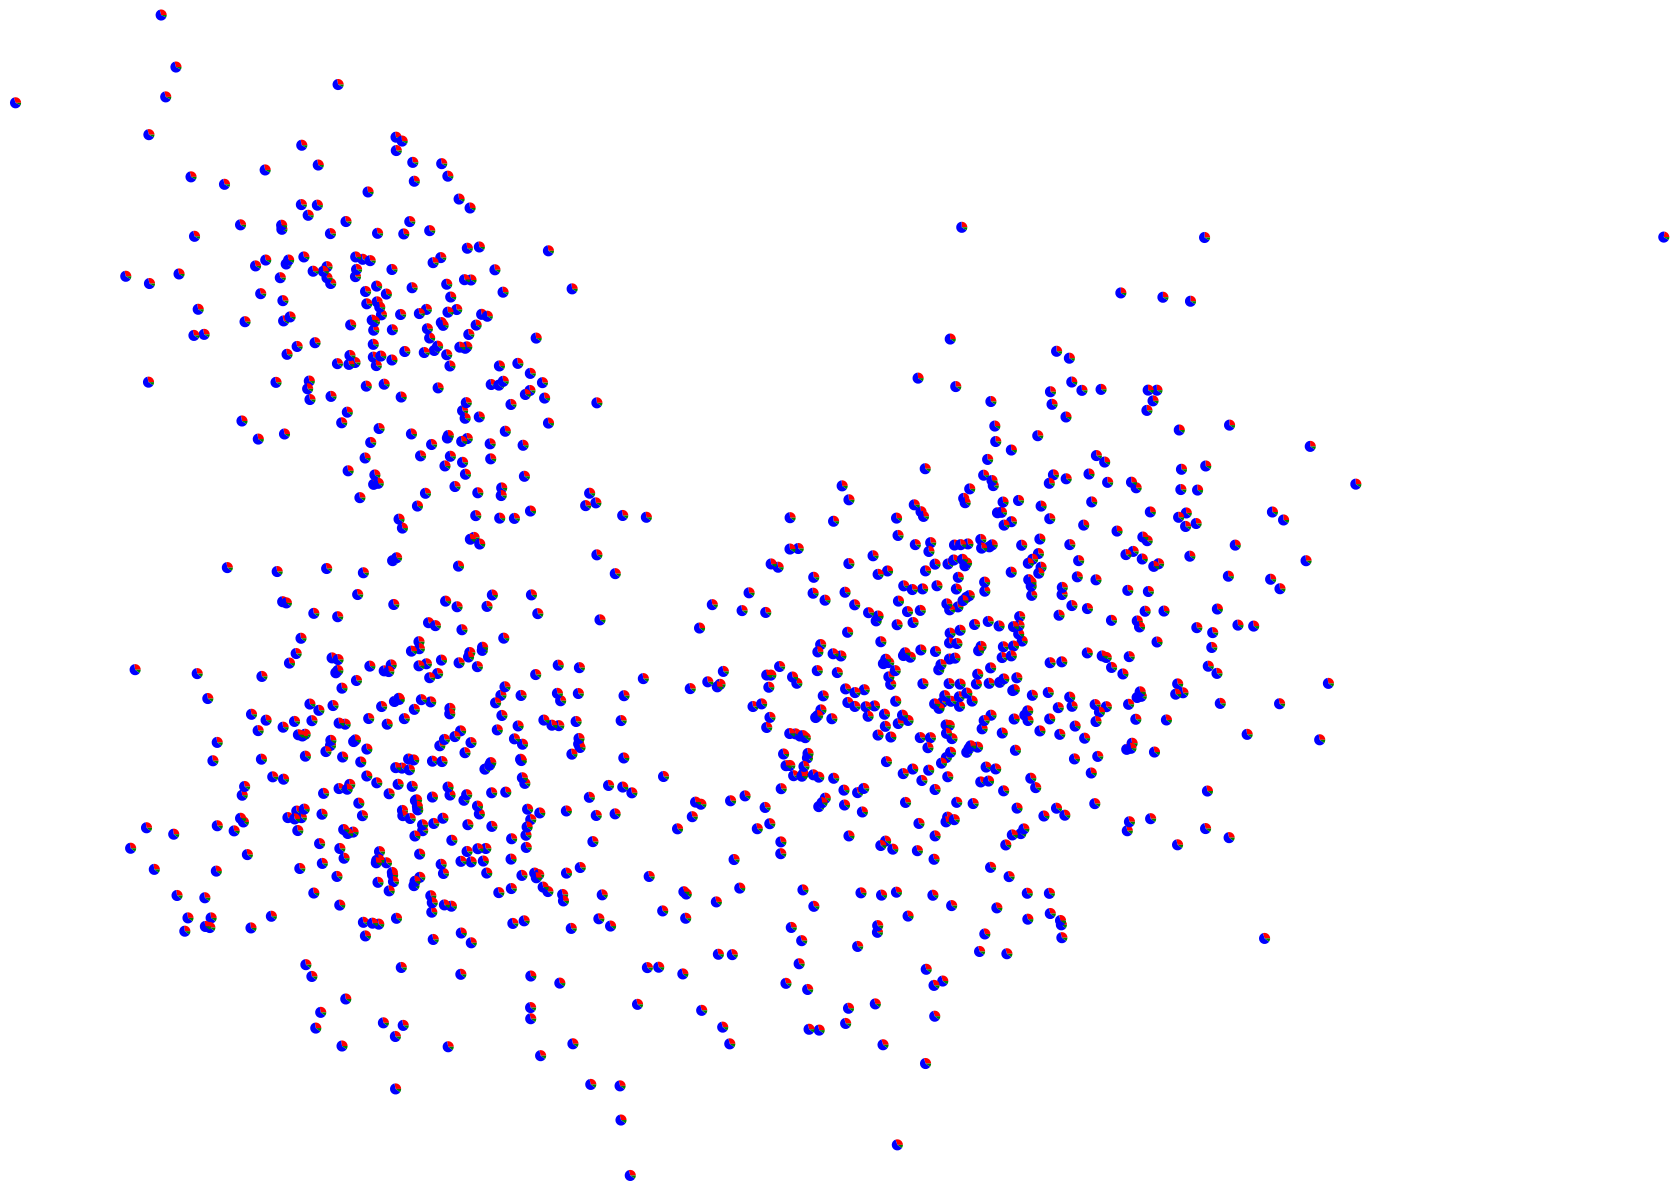

m: [[ 1.86103779  0.95630853]
 [ 0.31733186  0.16282459]
 [17.82538028  9.20656435]]
S: [[[ 1.68576597e+03 -7.68240072e+01]
  [-7.68240072e+01  7.58541534e+02]]

 [[ 9.89629145e+02  1.46792078e+02]
  [ 1.46792078e+02  3.80884334e+02]]

 [[ 1.73063961e+05  8.61239107e+04]
  [ 8.61239107e+04  4.72306477e+04]]]


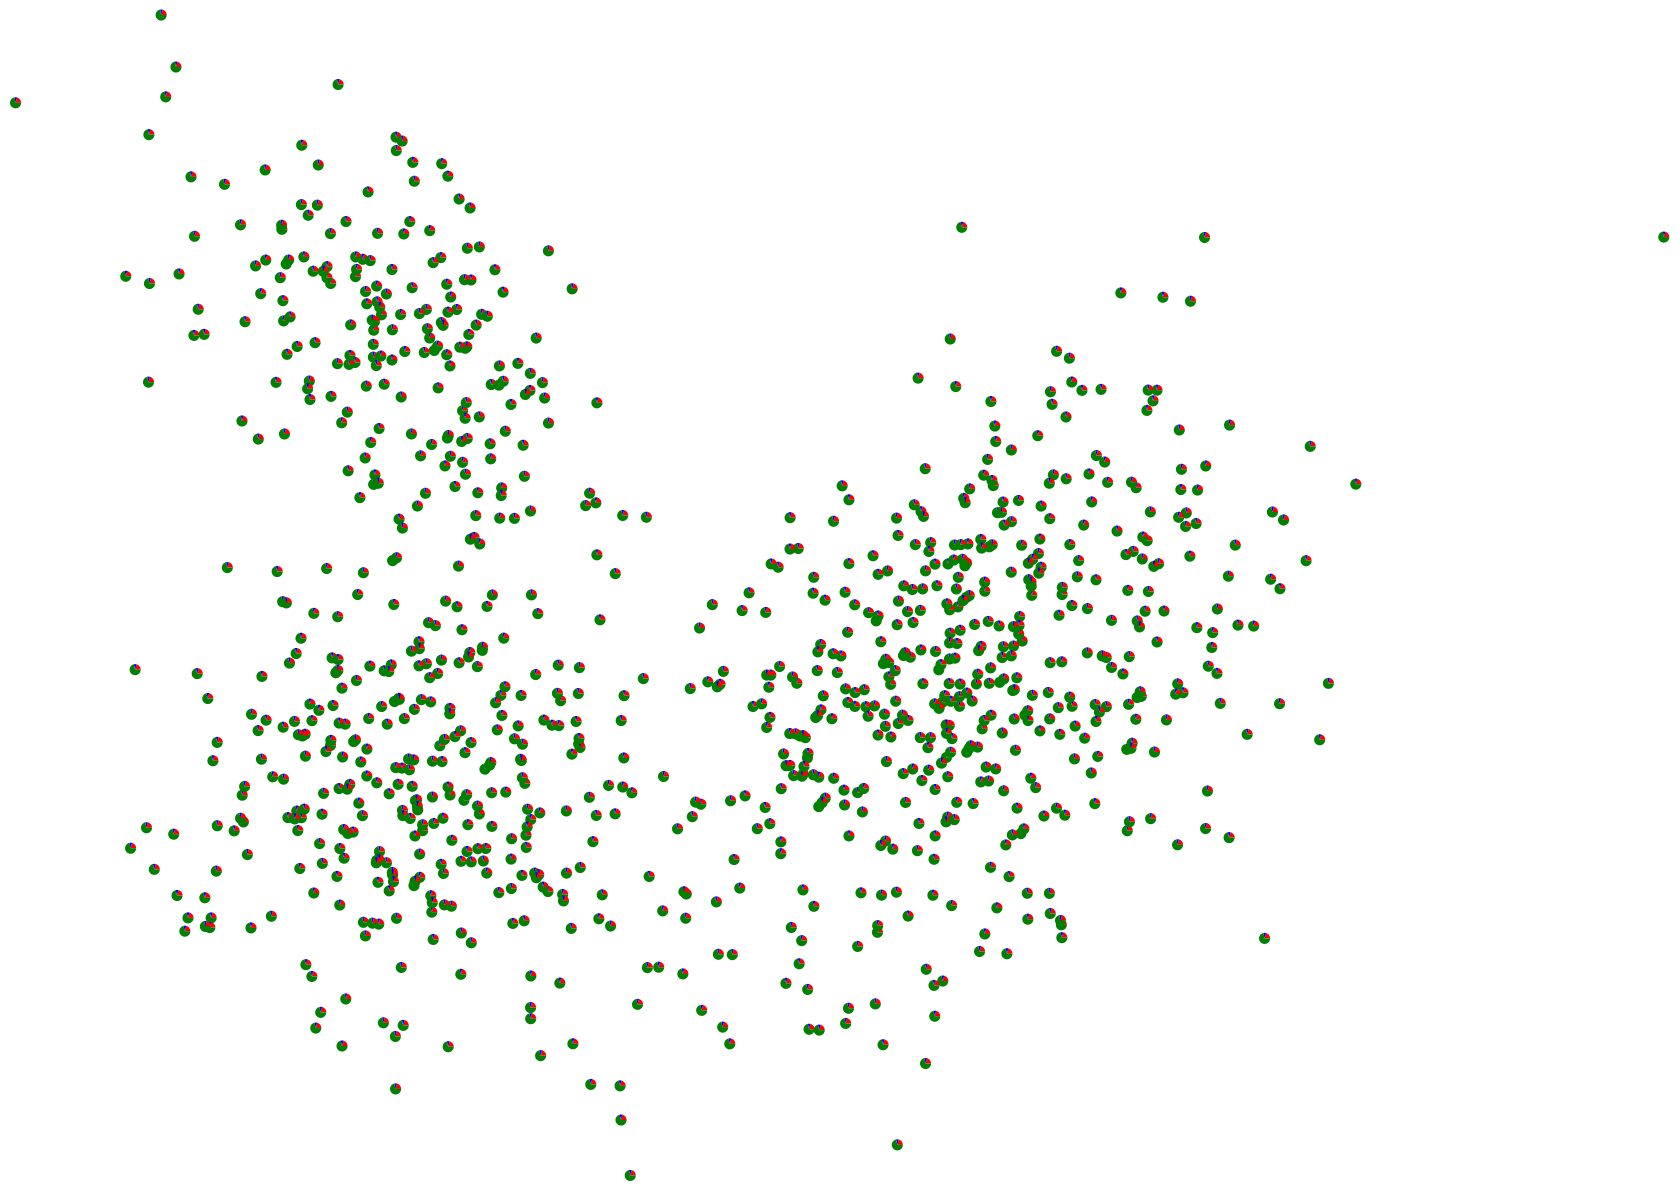

m: [[ 6.35819974  3.27214467]
 [12.15835872  6.29117108]
 [ 0.25968736  0.13343091]]
S: [[[12172.9220675   3837.0154142 ]
  [ 3837.0154142   4026.24249965]]

 [[39627.46759152 18704.8757139 ]
  [18704.8757139  11193.57975301]]

 [[  942.66483158   146.42470682]
  [  146.42470682   361.06032749]]]


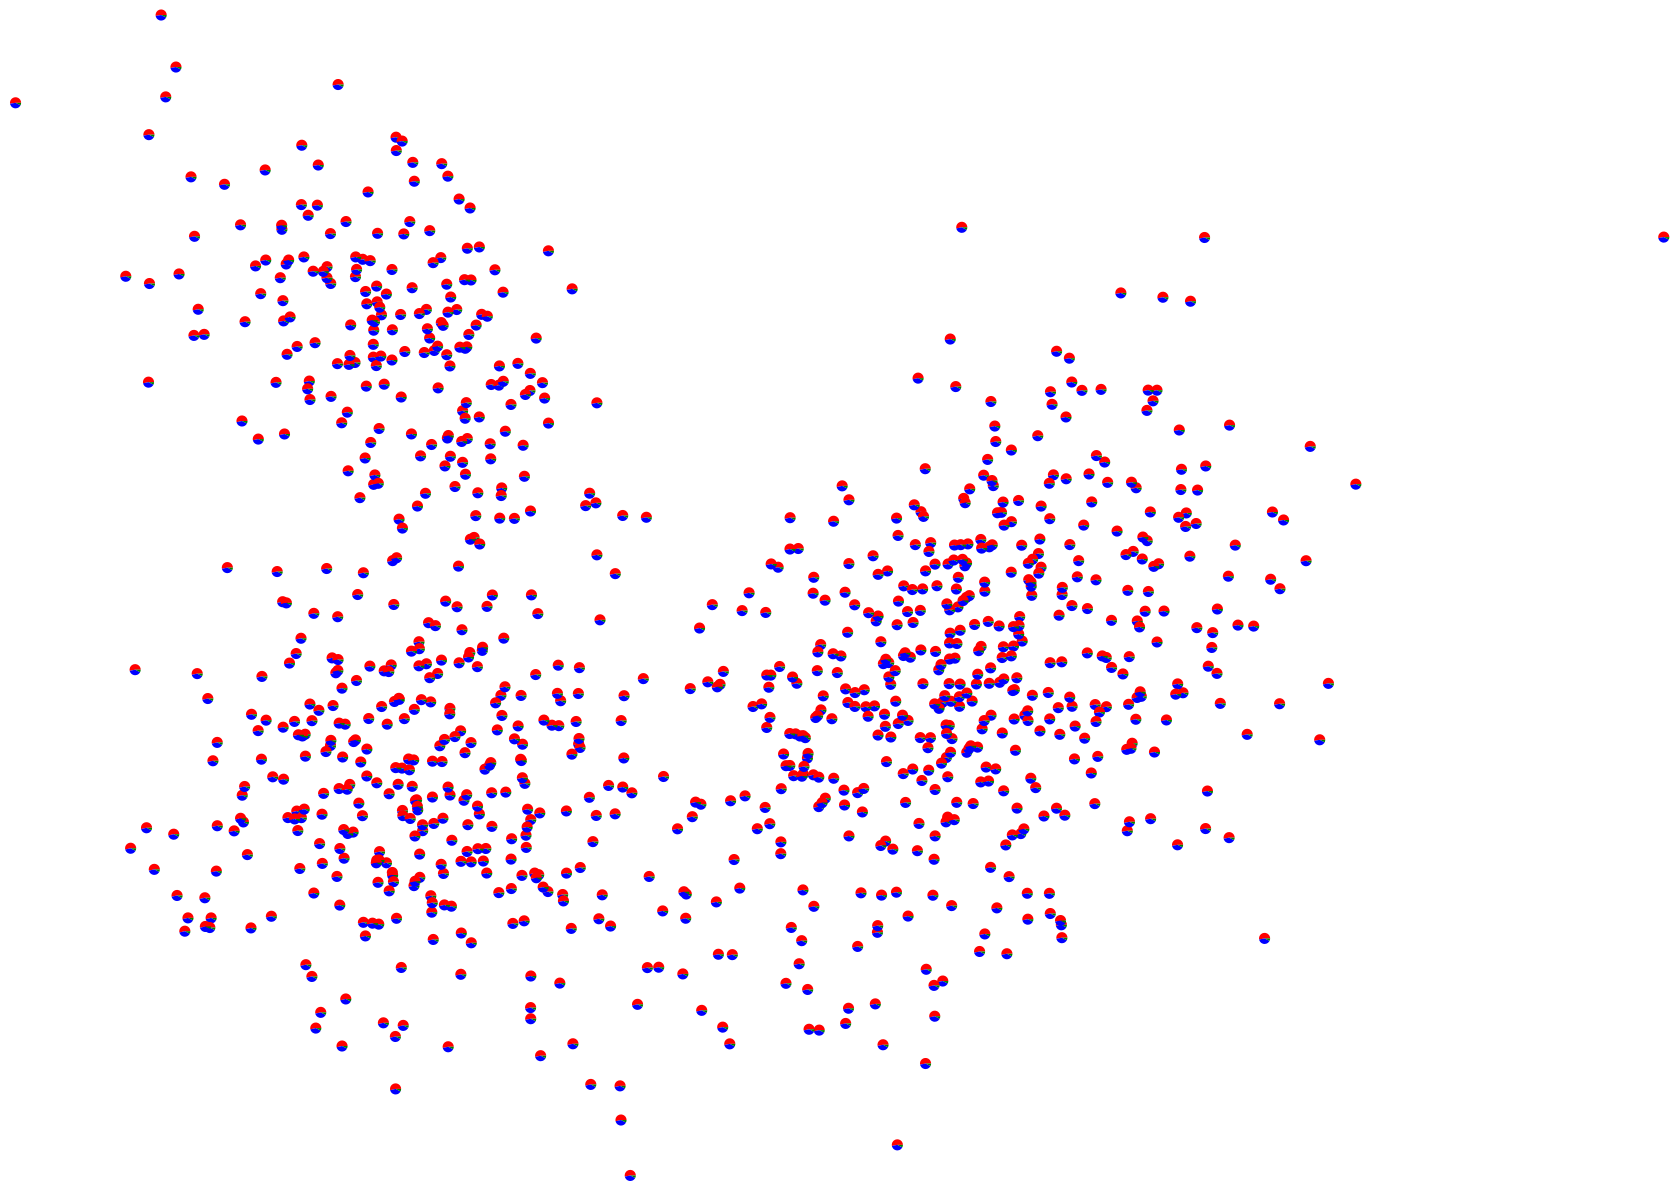

m: [[ 1.59301262  0.8183622 ]
 [ 0.964366    0.49568086]
 [16.78112336  8.68422531]]
S: [[[ 2.92142148e+03 -5.47137513e+01]
  [-5.47137513e+01  1.28813510e+03]]

 [[ 1.52384314e+03  9.31767753e+01]
  [ 9.31767753e+01  6.31620601e+02]]

 [[ 1.06871627e+05  5.29862817e+04]
  [ 5.29862817e+04  2.93728197e+04]]]


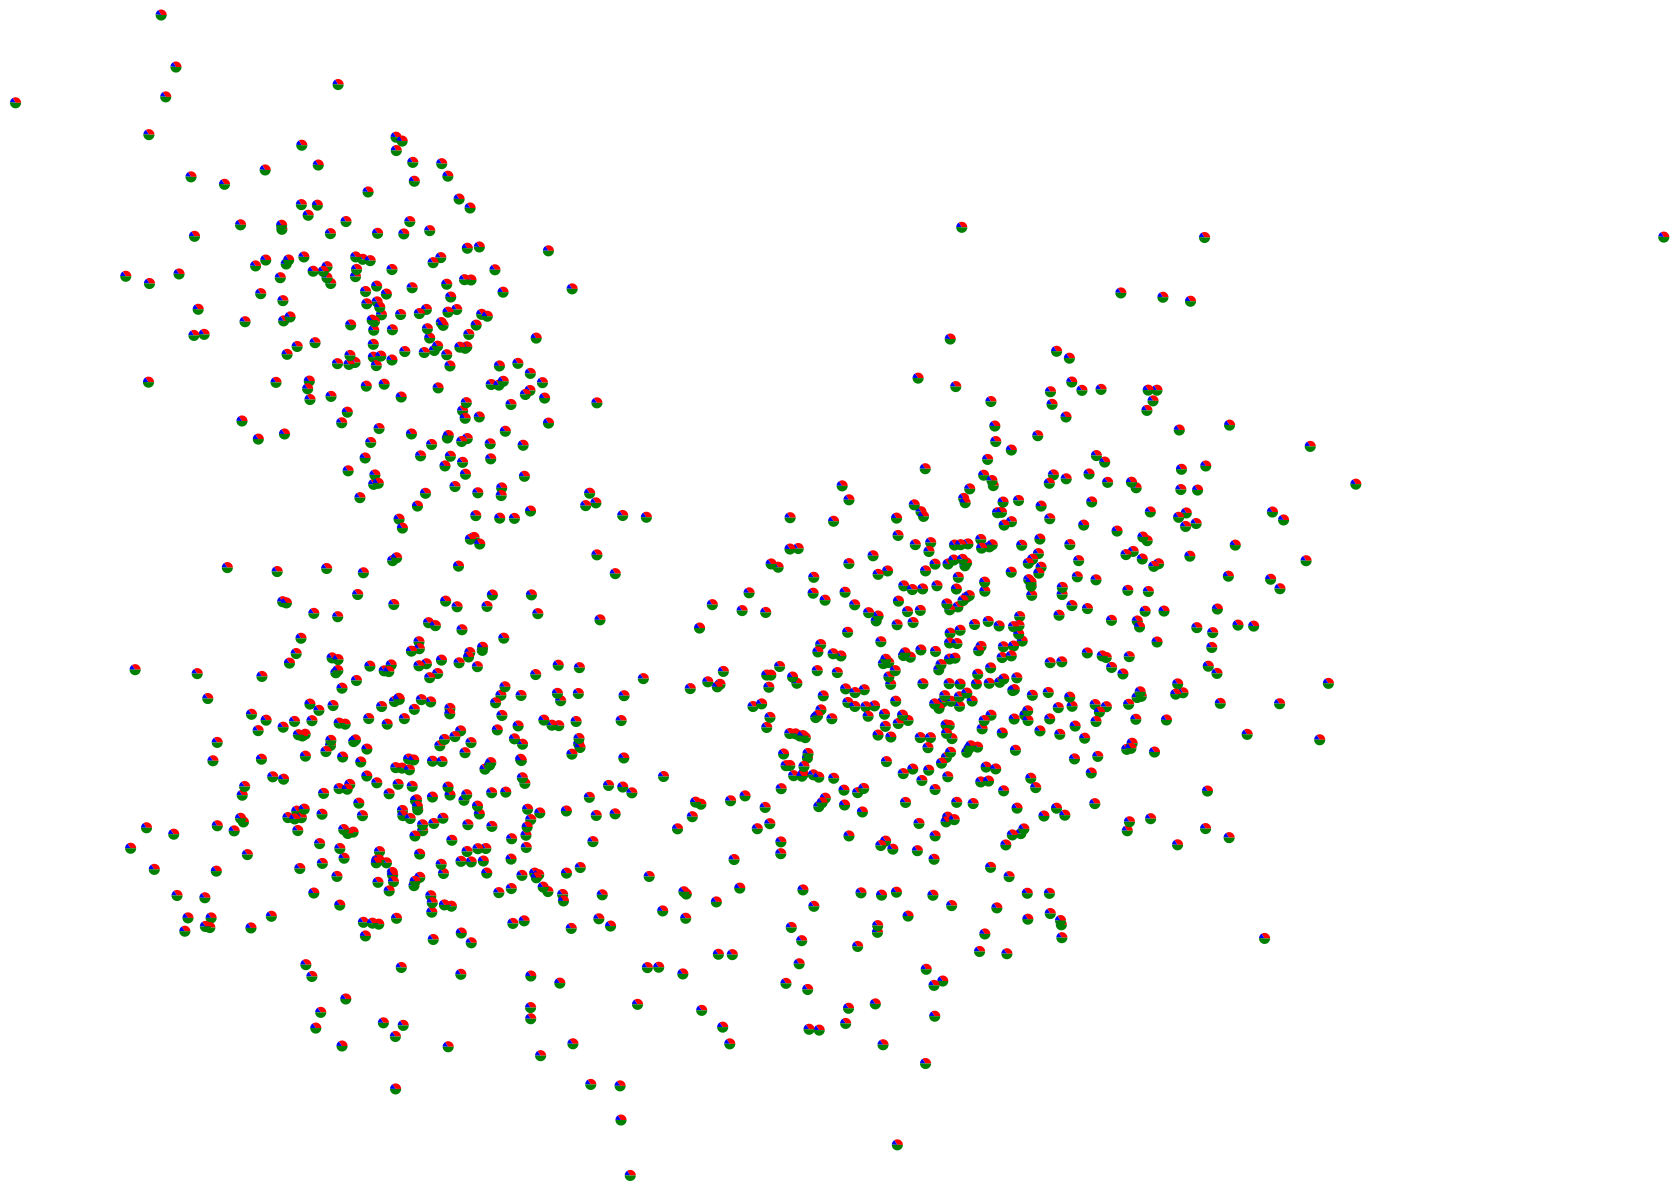

m: [[3.53762882 1.82244069]
 [7.05757634 3.64423136]
 [0.37596931 0.19364511]]
S: [[[4.34200308e+03 2.86772138e+00]
  [2.86772138e+00 1.88783171e+03]]

 [[1.24192746e+04 4.42946254e+03]
  [4.42946254e+03 3.95925899e+03]]

 [[9.28362144e+02 1.30133939e+02]
  [1.30133939e+02 3.61014995e+02]]]


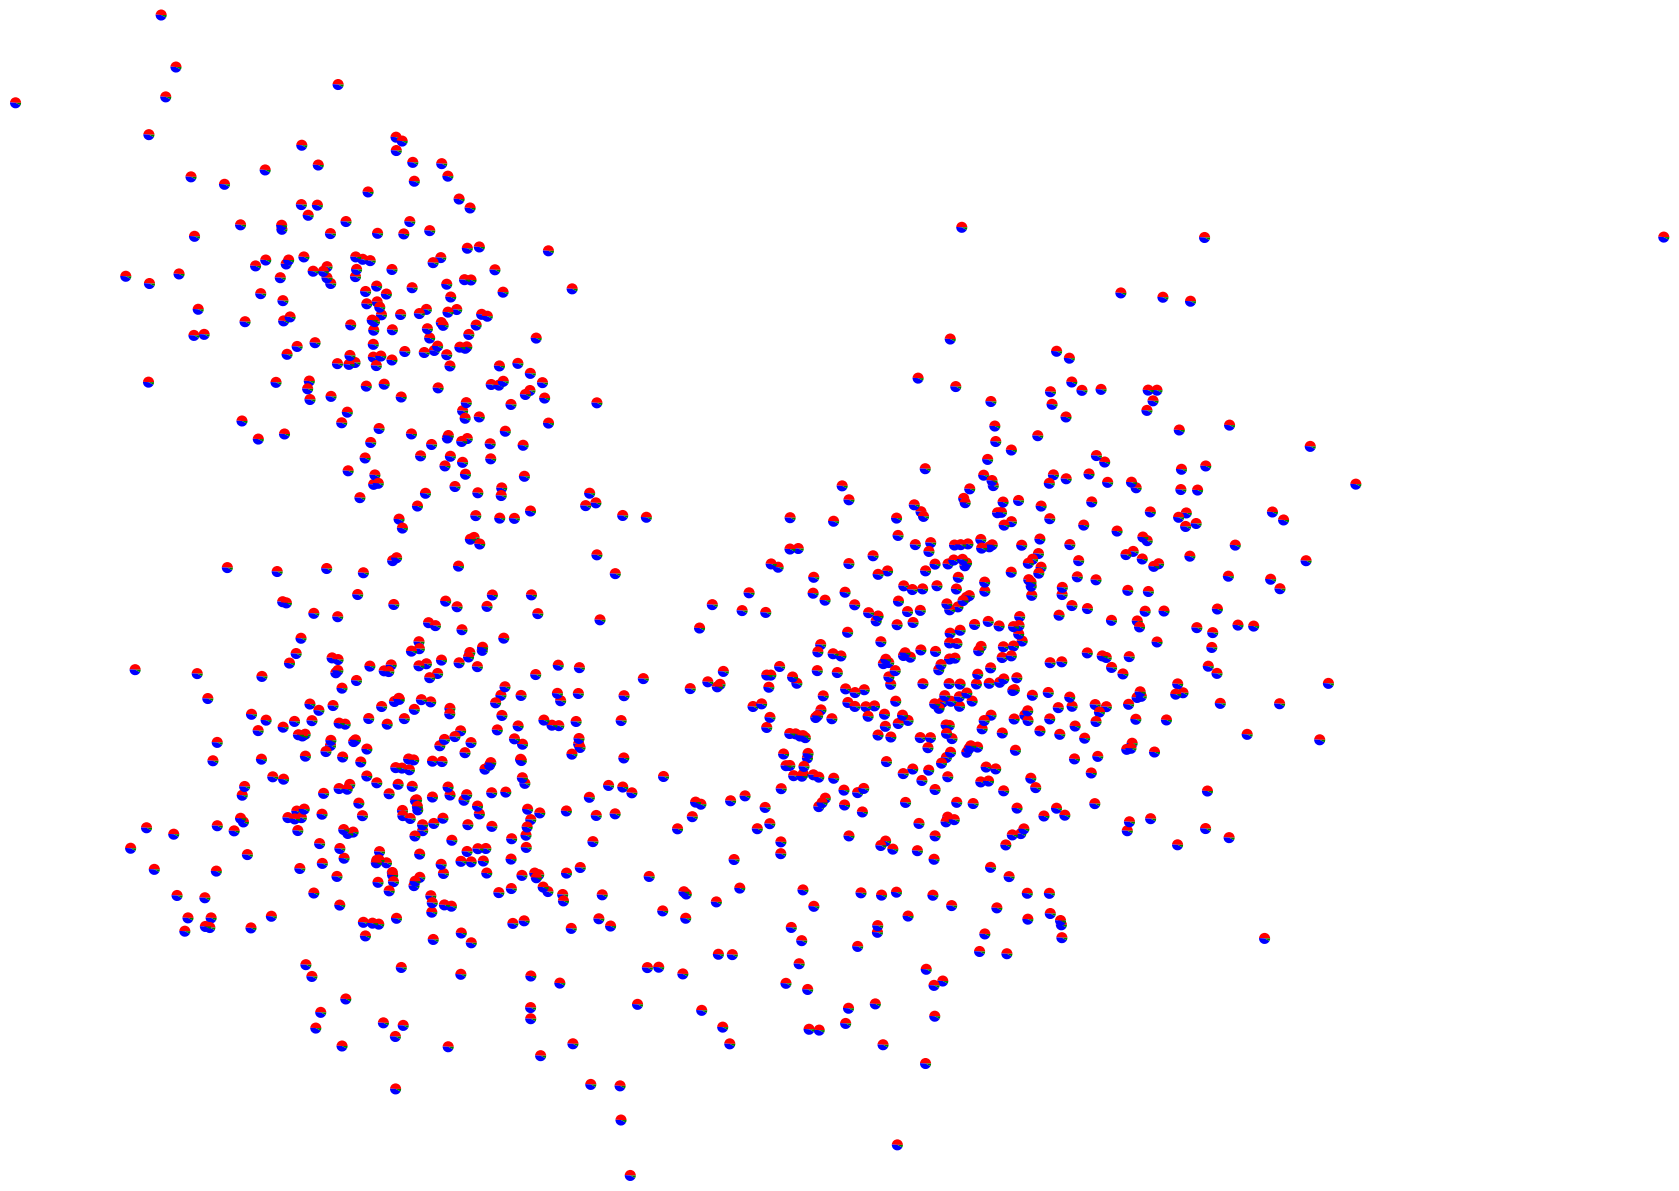

m: [[ 2.22968444  1.14676657]
 [ 1.17441978  0.60429545]
 [11.49036663  5.95204681]]
S: [[[ 3437.64577277  -234.68306078]
  [ -234.68306078  1572.58633744]]

 [[ 1934.32116592    62.79811859]
  [   62.79811859   820.52575896]]

 [[31370.14537855 14619.74377506]
  [14619.74377506  8943.9833938 ]]]


In [172]:
def multi_normal_pdf(x: np.ndarray, mean: np.ndarray, S: np.ndarray) -> np.ndarray:
    """calculates the pdf of a multivariate normal distribution with mean and Covariance matrix.

    Parameters
    ----------

    x: np.array, (n_dims,)
        the position at which the pdf is to be evaluated
    mean: np.array, (n_dims,)
        the mean

    S: np.array, (n_dims, n_dims)
        the covariance matrix of the normal distribution.
        needs to be positive definite.

    Returns
    -------

    p: int
        Probabily density function at point x
    """

    n_dims = x.shape[0]
    factor_1 = (2 * np.pi) ** -(n_dims / 2)
    factor_2 = np.linalg.det(S) ** -(1 / 2)
    exponent = (1 / 2) * (x - mean).T @ np.linalg.inv(S) @ (x - mean)
    factor_3 = np.exp(exponent)

    p = factor_1 * factor_2 * factor_3
    return p


def multi_input_pdf(X, mean, S):
    """Calculates the probability density function (pdf) of a multivariate normal distribution
    for multiple samples.

    Parameters
    ----------
    X : np.ndarray, (n_samples, n_dims)
        Array of samples where each row represents a sample.
    mean : np.ndarray, (n_dims,)
        Mean vector of the multivariate normal distribution.
    S : np.ndarray, (n_dims, n_dims)
        Covariance matrix of the multivariate normal distribution.
        It must be positive definite.

    Returns
    -------
    p : np.ndarray, (n_samples,)
        Array containing the pdf values corresponding to each sample in X.
    """
    return np.array([multi_normal_pdf(x, mean, S) for x in X])


def multi_cluster_pdf(X, means, Ss):
    """Calculates the probability density functions (pdfs) of samples with respect to
    multiple clusters defined by means and covariance matrices.

    Parameters
    ----------
    X : np.ndarray, (n_samples, n_dims)
        Array of samples where each row represents a sample.
    means : List[np.ndarray], (n_clusters, n_dims)
        List of mean vectors, each representing the mean of a cluster.
    Ss : List[np.ndarray], (n_clusters, n_dims, n_dims)
        List of covariance matrices, each representing the covariance matrix of a cluster.
        Each covariance matrix must be positive definite.

    Returns
    -------
    p : np.ndarray, (n_clusters, n_samples)
        Array containing the pdf values for each sample in X for each cluster.
        The (i, j)-th entry corresponds to the pdf of the j-th sample with respect to
        the i-th cluster defined by means[i] and Ss[i].
    """

    return np.array([multi_input_pdf(X, mean, S) for mean, S in zip(means, Ss)])


def fit_mog(
    x: np.ndarray, n_clusters: int, n_iters: int = 10, random_seed: int = 2046
) -> tuple[np.ndarray]:
    """Fit Mixture of Gaussian model using EM algo.

    Parameters
    ----------

    x: np.array, (n_samples, n_dims)
        Input data

    n_clusters: int
        Number of clusters

    n_iters: int
        Maximal number of iterations.

    random_seed: int
        Random Seed


    Returns
    -------

    labels: np.array, (n_samples)
        Cluster labels

    m: list or np.array, (n_clusters, n_dims)
        Means

    S: list or np.array, (n_clusters, n_dims, n_dims)
        Covariances

    p: list or np.array, (n_clusters, )
        Cluster weights / probablities
    """

    # ensure reproducibility using a random number generator
    rng = np.random.default_rng(random_seed)

    # fill in your code here

    # -----------
    # init (1 pt)
    # -----------

    # establish bounds for means
    upper = np.max(x, axis=0)
    lower = np.min(x, axis=0)
    diff = upper - lower

    n_dims = x.shape[1]

    # make random initial values
    m = rng.random(size=(n_clusters, n_dims)) * diff + lower
    S = rng.integers(low=1, high=3, size=(n_clusters, n_dims, n_dims))
    p = rng.random(size=(n_clusters, 1))

    # S must be positive semi-definite:
    # take the transpose along the last two axis
    S_T = np.transpose(S, axes=(0, 2, 1))
    # and selfmultiply
    S = S @ S_T
    S = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
    # p must be summing up to 1
    p = p / sum(p)

    print(p)
    # get N_cluster from p
    N = p * x.shape[0]

    # -------------------------
    # EM maximisation (2.5 pts)
    # -------------------------

    for step in range(n_iters):

        # Slides 17 & 18
        # E step
        # Evaluate the posterior probablibities `r`
        # using the current values of `m` and `S`

        # r.shape = (n_clusters, n_samples)

        # create the N(x_n|m_cluster, S_cluster)
        pdfs = multi_cluster_pdf(x, m, S)
        # print("pdfs:", pdfs.shape)
        # weigh by p_cluster through broadcasting
        likelyhood = pdfs * p
        # print("likelyhood:", likelyhood.shape)
        # we can sum over the cluster likelyhoods to get the denominator (Normalizer)
        normalizer = 1 / np.sum(likelyhood, axis=0)[np.newaxis, :]
        # print("normalizer:", normalizer.shape)
        r = likelyhood * normalizer
        # print("r:", r.shape)
        # M step
        # Estimate new `m`, `S` and `p`
        # m.shape = (n_clusters, n_dims)
        # update m
        m = (r @ x) / N
        print("m:", m)
        # S.shape = (n_clusters, n_dims, n_dims)
        # update S
        differences = (x[:, np.newaxis, :] - m)[..., np.newaxis, :]
        covs = np.transpose(differences, axes=(0, 1, 3, 2)) @ differences
        r_ext = r.T[:, :, np.newaxis, np.newaxis]
        S = np.sum((covs * r_ext), axis=0)
        print("S:", S)
        # update p and N
        N = np.sum(r, axis=1)[:, np.newaxis]
        p = N / x.shape[0]

        # get labels

        labels = np.argmax(r, axis=0)
        plt.cla()
        # plot clusters
        # plt.scatter(x[:, 0], x[:, 1], c=labels)
        # plot cluster means
        plt.scatter(m[:, 0], m[:, 1], c="r")
        for i, point in enumerate(x):
            plt.pie(r[:, i], center=point, radius=0.05, colors=["r", "b", "g"])

        plt.show()

    return labels, m, S, p


output = fit_mog(x, 3, n_iters=9)

array([[2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.]])

Run Mixture of Gaussian on toy data

In [13]:
# mog_labels, m, S, p = fit_mog(x, 3, random_seed=0)

Plot toy data with cluster assignments and compare to original labels

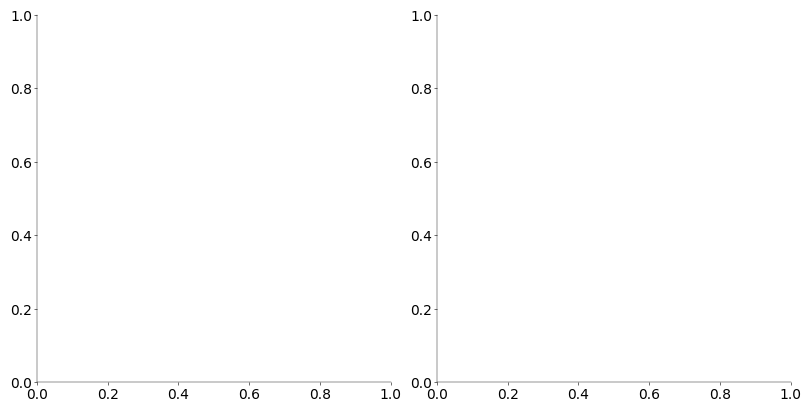

In [14]:
mosaic = [["True", "MoG"]]
fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(8, 4), layout="constrained")

# -----------------
# Add plot (0.5 pts)
# -----------------

## Task 3: Model complexity
A priori we do not know how many neurons we recorded. Extend your algorithm with an automatic procedure to select the appropriate number of mixture components (clusters). Base your decision on the Bayesian Information Criterion:

$BIC = -2L+P \log N,$

where $L$ is the log-likelihood of the data under the best model, $P$ is the number of parameters of the model and $N$ is the number of data points. You want to minimize the quantity. Plot the BIC as a function of mixture components. What is the optimal number of clusters on the toy dataset?

You can also use the BIC to make your algorithm robust against suboptimal solutions due to local minima. Start the algorithm multiple times and pick the best solutions for extra points. You will notice that this depends a lot on which initialization strategy you use.

*Grading: 3 pts*



In [15]:
def mog_bic(
    x: np.ndarray, m: np.ndarray, S: np.ndarray, p: np.ndarray
) -> tuple[float, float]:
    """Compute the BIC for a fitted Mixture of Gaussian model

    Parameters
    ----------

    x: np.array, (n_samples, n_dims)
        Input data

    m: np.array, (n_clusters, n_dims)
        Means

    S: np.array, (n_clusters, n_dims, n_dims)
        Covariances

    p: np.array, (n_clusters, )
        Cluster weights / probablities

    Return
    ------

    bic: float
        BIC

    LL: float
        Log Likelihood
    """

    # insert your code here

    # -------------------------
    # implement the BIC (1.5 pts)
    # -------------------------

    pass

In [16]:
# ---------------------------------------------------------------------------------------------------
# Compute and plot the BIC for mixture models with different numbers of clusters (e.g., 2 - 6). (0.5 pts)
# Make your algorithm robust against local minima. (0.5 pts) and plot the result (0.5 pts)
# ---------------------------------------------------------------------------------------------------

K = range(2, 7)
num_seeds = 10

BIC = np.zeros((num_seeds, len(K)))
LL = np.zeros((num_seeds, len(K)))

# run mog and BIC multiple times here

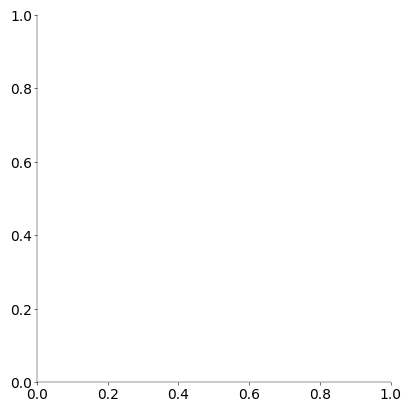

In [17]:
fig, ax = plt.subplots(figsize=(4, 4))
# plot BIC

## Task 4: Spike sorting using Mixture of Gaussian 
Run the full algorithm on your set of extracted features (including model complexity selection). Plot the BIC as a function of the number of mixture components on the real data. For the best model, make scatter plots of the first PCs on all four channels (6 plots). Color-code each data point according to its class label in the model with the optimal number of clusters. In addition, indicate the position (mean) of the clusters in your plot. 

*Grading: 3 pts*


In [18]:
# ------------------------------------------------------------------------------------------
# Select the model that best represents the data according to the BIC (include plot) (1 pt)
# ------------------------------------------------------------------------------------------

K = np.arange(2, 16)
num_seeds = 5

BIC = np.zeros((num_seeds, len(K)))
LL = np.zeros((num_seeds, len(K)))

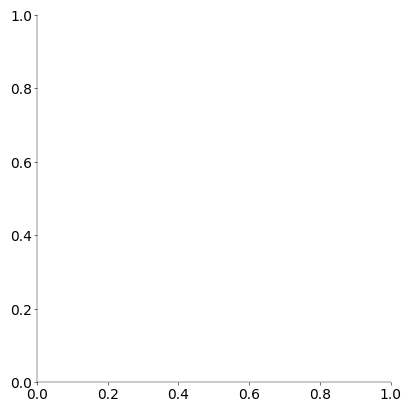

In [19]:
fig, ax = plt.subplots(figsize=(4, 4))

# plot BIC

Refit model with lowest BIC and plot data points

In [20]:
random_seed, kk = np.where(BIC == BIC.min())
random_seed = random_seed[0]
kk = kk[0]
print(f"lowest BIC: # cluster = {K[kk]}")
# a, m, S, p = fit_mog(b, K[kk], random_seed=random_seed)

lowest BIC: # cluster = 2


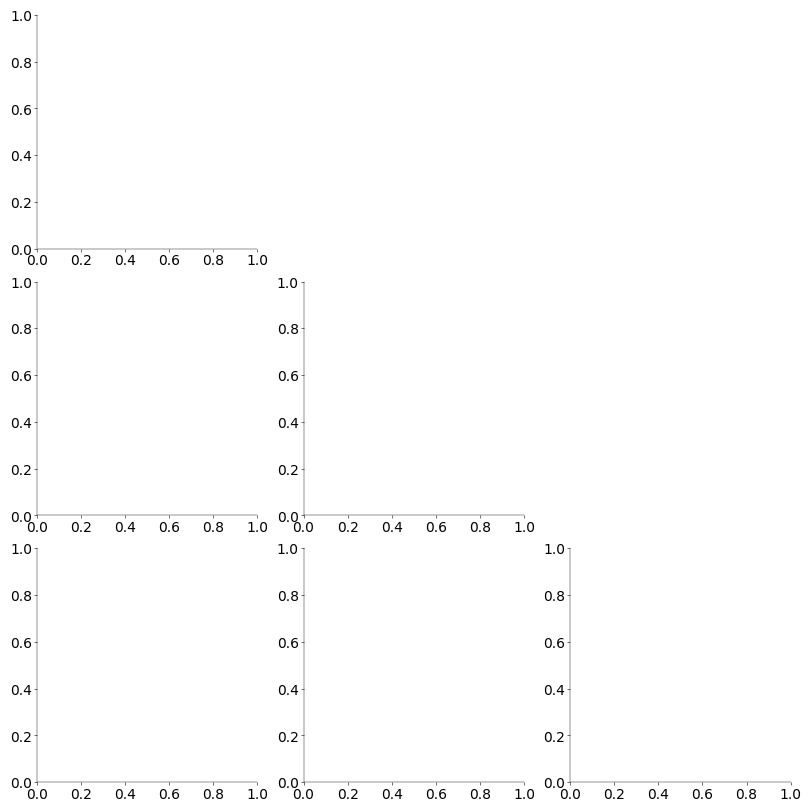

In [21]:
# -------------------------------------------------------------------------------------
# Create scatterplots of the first PCs under the best model for all 4 channels. (2 pts)
# -------------------------------------------------------------------------------------


mosaic = [
    ["Ch2 vs Ch1", ".", "."],
    ["Ch3 vs Ch1", "Ch3 vs Ch2", "."],
    ["Ch4 vs Ch1", "Ch4 vs Ch2", "Ch4 vs Ch3"],
]
fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(8, 8), layout="constrained")

### Task 5: Cluster separation

Implement linear discriminant analysis to visualize how well each cluster is separated from its neighbors in the high-dimensional space in the function `separation()`. Project the spikes of each pair of clusters onto the axis that optimally separates those two clusters. 

Plot a matrix with pairwise separation plots, showing the histogram of the points in both clusters projected on the axis best separating the clusters (as shown in the lecture). *Hint:* Since Python 3.5+, matrix multiplications can be compactely written as `x@y`.

*Grading: 4 pts*


In [22]:
def separation(
    b: np.ndarray,
    m: np.ndarray,
    S: np.ndarray,
    assignment: np.ndarray,
    n_bins: int = 50,
):
    """Calculate cluster separation by LDA.

    proj, bins = separation(b, m, S, p, assignment)
    projects the data on the LDA axis for all pairs of clusters. The result
    is normalized such that the left (i.e. first) cluster has
    zero mean and unit variances. The LDA axis is estimated from the model.
    ---

    Parameters
    ----------
    b: np.array, (n_spikes, n_features)
        Features.

    m: np.array, (n_clusters, n_features)
        Means.

    S: np.array, (n_clusters, n_features, n_features)
        Covariance.

    assignment: np.array, (n_spikes, )
        Cluster assignments / labels for each spike

    n_bins: int
        Number of bins in a lda histogram.


    Returns
    -------

    proj: np.array, (n_bins, n_clusters, n_clusters)
        computed lda histo# Comparing the cells in particular

    bins: np.array, (n_bins)
        bin times relative to center    #bins x 1
    """

    # insert your code here

    # ---------------------------------------------------------------------
    # compute the optimal separating axes for each pair of clusters (2 pts)
    # ---------------------------------------------------------------------

    # -------------------------------------------
    # normalise according to first cluster (1 pt)
    # -------------------------------------------

    # --------------------------------------
    # plot histograms on optimal axis (1 pt)
    # --------------------------------------

    return proj, bins

In [23]:
# proj, bins = separation(b, m, S, a)